<hr>
<h1>Predicting Abnormalities in Mammograms</h1>

<p>Jay Narhan</p>
May 2017

This notebook extends the previous submission to include classifications across three classes - Normal, Benign and Malignant images.

<hr>

In [1]:
import os
import sys
import time
import numpy as np

import sklearn.metrics as skm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from skimage import color

import keras.callbacks as cb
import keras.utils.np_utils as np_utils
from keras import applications
from keras import regularizers
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, GaussianNoise

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10)
np.set_printoptions(precision=2)

import jn_bc_helper as bc

Using Theano backend.


<h2>Reproducible Research</h2>

In [2]:
%%python
import os
os.system('python -V')
os.system('python ../../Package_Versions.py')

scipy:           0.19.0
numpy:           1.12.1
matplotlib:      2.0.0
sklearn:         0.18.1
skimage:         0.13.0
theano:          0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
tensorflow:      0.10.0
keras:           2.0.3


Python 2.7.13 :: Continuum Analytics, Inc.
Using Theano backend.


In [3]:
SEED = 7
np.random.seed(SEED)

DATA_DIR = '/Users/jnarhan/Projects/CUNY_698/Docker-Shared/Data_Diff_Images/ALL_IMGS/'
meta_file = DATA_DIR + 'update_meta_pathology.csv'
PATHO_INX = 4   # Column number of Pathology in meta_file
FILE_INX = 1    # Column number of File name in meta_file

meta_data, cls_cnts = bc.load_meta(meta_file, patho_idx=PATHO_INX, file_idx=FILE_INX,
                                   balanceByRemoval=True, verbose=True)

bc.pprint('Loading data:')
cats = bc.bcNumericsPaths()

# For smaller images supply tuple argument for a parameter 'imgResize':
X_data, Y_data = bc.load_data(meta_data, DATA_DIR, cats, imgResize=(150,150)) 


2it [00:00, 14.70it/s]

----------------
Before Balancing
----------------
benign    : 569
malignant : 812
normal    : 1072
balanceViaRemoval.avgC: 817
balanceViaRemoval.theshold: 817.0
---------------
After Balancing
---------------
benign    : 569
malignant : 732
normal    : 732
-------------
Loading data:
-------------


2033it [01:24, 23.93it/s]


**Create the Training and Test Datasets**

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data,
                                                    test_size=0.25,
                                                    random_state=SEED,
                                                    stratify=zip(*Y_data)[0])

print 'Size of X_train: {:>5}'.format(len(X_train))
print 'Size of X_test: {:>5}'.format(len(X_test))
print 'Size of Y_train: {:>5}'.format(len(Y_train))
print 'Size of Y_test: {:>5}'.format(len(Y_test))

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

data = [X_train, X_test, Y_train, Y_test]

Size of X_train:  1524
Size of X_test:   509
Size of Y_train:  1524
Size of Y_test:   509
(1524, 150, 150)
(509, 150, 150)
(1524, 1)
(509, 1)


<h2>Support Vector Machine Model</h2>

In [5]:
X_train_svm = X_train.reshape( (X_train.shape[0], -1)) 
X_test_svm  = X_test.reshape( (X_test.shape[0], -1))

In [6]:
SVM_model = SVC(gamma=0.001)
SVM_model.fit( X_train_svm, Y_train)

/Users/jnarhan/miniconda2/envs/bc_venv/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
predictOutput = SVM_model.predict(X_test_svm)
svm_acc = metrics.accuracy_score(y_true=Y_test, y_pred=predictOutput)

print 'SVM Accuracy: {: >7.2f}%'.format(svm_acc * 100)
print 'SVM Error: {: >10.2f}%'.format(100 - svm_acc * 100)

SVM Accuracy:   64.83%
SVM Error:      35.17%


Normalized confusion matrix
[[ 0.78  0.13  0.09]
 [ 0.07  0.56  0.37]
 [ 0.27  0.14  0.58]]


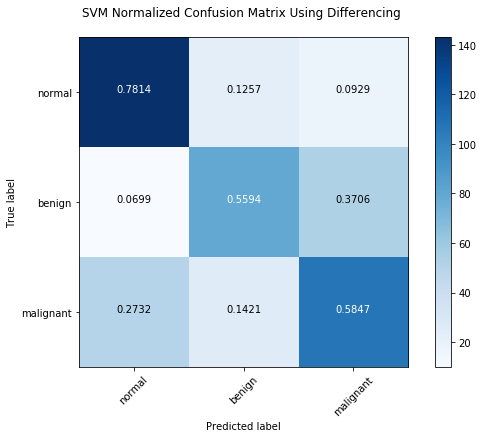

In [8]:
svm_matrix = skm.confusion_matrix(y_true=Y_test, y_pred=predictOutput)
numBC = bc.reverseDict(cats)
class_names = numBC.values()

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=True, 
                         title='SVM Normalized Confusion Matrix Using Differencing \n')
plt.savefig('./cm_figures/jn_SVM_3Class_Diff_CM_20170508.png', dpi=100)

<h2>CNN Modelling Using VGG16 in Transfer Learning</h2>

In [9]:
def VGG_Prep(img_data):
    """
    :param img_data: training or test images of shape [#images, height, width]
    :return: the array transformed to the correct shape for the VGG network
                shape = [#images, height, width, 3] transforms to rgb and reshapes
    """
    images = np.zeros([len(img_data), img_data.shape[1], img_data.shape[2], 3])
    for i in range(0, len(img_data)):
        im = (img_data[i] * 255)        # Original imagenet images were not rescaled
        im = color.gray2rgb(im)
        images[i] = im
    return(images)

In [10]:
def vgg16_bottleneck(data, modelPath, fn_train_feats, fn_train_lbls, fn_test_feats, fn_test_lbls):
    # Loading data
    X_train, X_test, Y_train, Y_test = data
    
    print('Preparing the Training Data for the VGG_16 Model.')
    X_train = VGG_Prep(X_train)
    print('Preparing the Test Data for the VGG_16 Model')
    X_test = VGG_Prep(X_test)
        
    print('Loading the VGG_16 Model')
    # "model" excludes top layer of VGG16:
    model = applications.VGG16(include_top=False, weights='imagenet') 
        
    # Generating the bottleneck features for the training data
    print('Evaluating the VGG_16 Model on the Training Data')
    bottleneck_features_train = model.predict(X_train)
    
    # Saving the bottleneck features for the training data
    featuresTrain = os.path.join(modelPath, fn_train_feats)
    labelsTrain = os.path.join(modelPath, fn_train_lbls)
    print('Saving the Training Data Bottleneck Features.')
    np.save(open(featuresTrain, 'wb'), bottleneck_features_train)
    np.save(open(labelsTrain, 'wb'), Y_train)

    # Generating the bottleneck features for the test data
    print('Evaluating the VGG_16 Model on the Test Data')
    bottleneck_features_test = model.predict(X_test)
    
    # Saving the bottleneck features for the test data
    featuresTest = os.path.join(modelPath, fn_test_feats)
    labelsTest = os.path.join(modelPath, fn_test_lbls)
    print('Saving the Test Data Bottleneck Feaures.')
    np.save(open(featuresTest, 'wb'), bottleneck_features_test)
    np.save(open(labelsTest, 'wb'), Y_test)

In [11]:
# Locations for the bottleneck and labels files that we need
train_bottleneck = '3Class_VGG16_bottleneck_features_train.npy'
train_labels     = '3Class_VGG16_labels_train.npy'
test_bottleneck  = '3Class_VGG16_bottleneck_features_test.npy'
test_labels      = '3Class_VGG16_labels_test.npy'
modelPath = os.getcwd()

top_model_weights_path = './weights/'

np.random.seed(SEED)
vgg16_bottleneck(data, modelPath, train_bottleneck, train_labels, test_bottleneck, test_labels)

Preparing the Training Data for the VGG_16 Model.
Preparing the Test Data for the VGG_16 Model
Loading the VGG_16 Model
Evaluating the VGG_16 Model on the Training Data
Saving the Training Data Bottleneck Features.
Evaluating the VGG_16 Model on the Test Data
Saving the Test Data Bottleneck Feaures.


In [12]:
def train_top_model(train_feats, train_lab, test_feats, test_lab, model_path, model_save, epoch = 50, batch = 64):
    start_time = time.time()
    
    train_bottleneck = os.path.join(model_path, train_feats)
    train_labels = os.path.join(model_path, train_lab)
    test_bottleneck = os.path.join(model_path, test_feats)
    test_labels = os.path.join(model_path, test_lab)
    
    history = bc.LossHistory()
    
    X_train = np.load(train_bottleneck)
    Y_train = np.load(train_labels)
    Y_train = np_utils.to_categorical(Y_train, num_classes=3)
    
    X_test = np.load(test_bottleneck)
    Y_test = np.load(test_labels)
    Y_test = np_utils.to_categorical(Y_test, num_classes=3)
    
    print X_train.shape
    print X_test.shape
    print Y_train.shape
    print Y_test.shape
    
    print X_train.shape[1:]

    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add( Dropout(0.7))
    
    model.add( Dense(256, activation='relu', kernel_constraint= maxnorm(3.)) )
    model.add( Dropout(0.5))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              epochs=epoch,
              batch_size=batch,
              callbacks=[history],
              validation_data=(X_test, Y_test),
              verbose=2)
    
    print "Training duration : {0}".format(time.time() - start_time)
    score = model.evaluate(X_test, Y_test, batch_size=16, verbose=2)

    print "Network's test score [loss, accuracy]: {0}".format(score)
    print 'CNN Error: {:.2f}%'.format(100 - score[1] * 100)
    
    bc.save_model(model_save, model, "jn_VGG16_3_Class_top_weights.h5")
    
    return model, history.losses, history.acc, score

(1524, 4, 4, 512)
(509, 4, 4, 512)
(1524, 3)
(509, 3)
(4, 4, 512)
Train on 1524 samples, validate on 509 samples
Epoch 1/100
1s - loss: 5.7531 - acc: 0.5853 - val_loss: 6.0284 - val_acc: 0.5815
Epoch 2/100
1s - loss: 5.1352 - acc: 0.6339 - val_loss: 4.9878 - val_acc: 0.6444
Epoch 3/100
1s - loss: 5.1671 - acc: 0.6365 - val_loss: 4.9697 - val_acc: 0.6523
Epoch 4/100
1s - loss: 4.7842 - acc: 0.6673 - val_loss: 5.2104 - val_acc: 0.6365
Epoch 5/100
1s - loss: 4.7432 - acc: 0.6627 - val_loss: 4.8438 - val_acc: 0.6503
Epoch 6/100
1s - loss: 4.7053 - acc: 0.6673 - val_loss: 5.2823 - val_acc: 0.6306
Epoch 7/100
1s - loss: 4.5994 - acc: 0.6772 - val_loss: 4.9347 - val_acc: 0.6523
Epoch 8/100
1s - loss: 4.5386 - acc: 0.6791 - val_loss: 4.6144 - val_acc: 0.6640
Epoch 9/100
1s - loss: 4.1838 - acc: 0.6942 - val_loss: 4.4524 - val_acc: 0.6739
Epoch 10/100
1s - loss: 4.2259 - acc: 0.6890 - val_loss: 4.9654 - val_acc: 0.6483
Epoch 11/100
1s - loss: 4.1711 - acc: 0.6890 - val_loss: 5.0477 - val_acc: 0

1s - loss: 0.4415 - acc: 0.8681 - val_loss: 1.3363 - val_acc: 0.7033
Training duration : 127.989173174
Network's test score [loss, accuracy]: [1.3362679822271606, 0.70333988247311185]
CNN Error: 29.67%
Model and Weights Saved to Disk


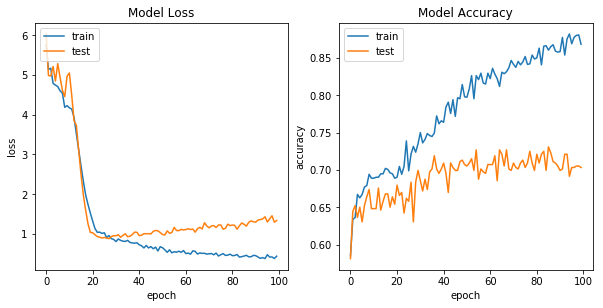

In [13]:
np.random.seed(SEED)
(trans_model, loss_cnn, acc_cnn, test_score_cnn) = train_top_model(train_feats=train_bottleneck,
                                                                   train_lab=train_labels, 
                                                                   test_feats=test_bottleneck, 
                                                                   test_lab=test_labels,
                                                                   model_path=modelPath, 
                                                                   model_save=top_model_weights_path,
                                                                   epoch=100)

plt.figure(figsize=(10,10))
bc.plot_losses(loss_cnn, acc_cnn)
plt.savefig('./epoch_figures/jn_Transfer_3Class_Learning_20170508.png', dpi=100)

Transfer Learning CNN Accuracy:   70.33%
Transfer Learning CNN Error:      29.67%
Normalized confusion matrix
[[ 0.87  0.05  0.08]
 [ 0.09  0.6   0.31]
 [ 0.25  0.13  0.62]]


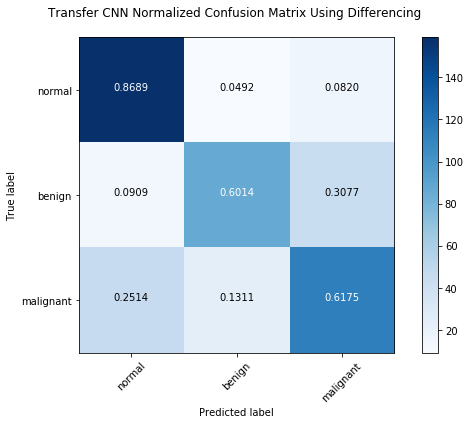

In [14]:
print 'Transfer Learning CNN Accuracy: {: >7.2f}%'.format(test_score_cnn[1] * 100)
print 'Transfer Learning CNN Error: {: >10.2f}%'.format(100 - test_score_cnn[1] * 100)

predictOutput = bc.predict(trans_model, np.load(test_bottleneck))
trans_matrix = skm.confusion_matrix(y_true=Y_test, y_pred=predictOutput)

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(trans_matrix, classes=class_names, normalize=True,
                         title='Transfer CNN Normalized Confusion Matrix Using Differencing \n')
plt.tight_layout()
plt.savefig('./cm_figures/jn_Transfer_3Class_Diff_CM_20170508.png', dpi=100)

*Note - overall accuracy in the 3 class situation, is actually improved if using an unbalanced data set (~73%). Just a sign of the fact that we have very limited data here.*

<h2>Core CNN Modelling</h2>

**Prep and package the data for Keras processing:**

In [15]:
data = [X_train, X_test, Y_train, Y_test]
X_train, X_test, Y_train, Y_test = bc.prep_data(data, cats)
data = [X_train, X_test, Y_train, Y_test]

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

Prep data for NNs ...
Data Prepped for Neural Nets.
(1524, 1, 150, 150)
(509, 1, 150, 150)
(1524, 3)
(509, 3)


**Heavy Regularization**

In [16]:
def diff_model_v7_reg(numClasses, input_shape=(3, 150,150), add_noise=False, noise=0.01, verbose=False):
    model = Sequential()
    if (add_noise):
        model.add( GaussianNoise(noise, input_shape=input_shape))
        model.add( Convolution2D(filters=16, 
                                 kernel_size=(5,5), 
                                 data_format='channels_first',
                                 padding='same',
                                 activation='relu'))
    else:
        model.add( Convolution2D(filters=16, 
                                 kernel_size=(5,5), 
                                 data_format='channels_first',
                                 padding='same',
                                 activation='relu',
                                 input_shape=input_shape))
    model.add( Dropout(0.7))
    
    model.add( Convolution2D(filters=32, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu'))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    model.add( Dropout(0.4))
    model.add( Convolution2D(filters=32, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu'))
    
    model.add( Convolution2D(filters=64, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    model.add( Convolution2D(filters=64, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( Dropout(0.4))
    
    model.add( Convolution2D(filters=128, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    
    model.add( Convolution2D(filters=128, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.4))
    
    model.add( Flatten())
    
    model.add( Dense(128, activation='relu', kernel_constraint= maxnorm(3.)) )
    model.add( Dropout(0.4))
    
    model.add( Dense(64, activation='relu', kernel_constraint= maxnorm(3.)) )
    model.add( Dropout(0.4))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(numClasses, activation='softmax'))
    
    if verbose:
        print( model.summary() )
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [17]:
diff_model7_noise_reg = diff_model_v7_reg(len(cats),
                                          input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                                          add_noise=True, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 1, 150, 150)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 150, 150)      416       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 150, 150)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 150, 150)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 75, 75)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 73, 73)        9248      
__________

Training model...
Train on 1524 samples, validate on 509 samples
Epoch 1/50
159s - loss: 2.5998 - acc: 0.4849 - val_loss: 1.7380 - val_acc: 0.5029
Epoch 2/50
150s - loss: 1.3163 - acc: 0.5879 - val_loss: 1.2184 - val_acc: 0.4637
Epoch 3/50
149s - loss: 0.9864 - acc: 0.6076 - val_loss: 1.0117 - val_acc: 0.5521
Epoch 4/50
150s - loss: 0.8883 - acc: 0.6220 - val_loss: 0.9381 - val_acc: 0.5599
Epoch 5/50
150s - loss: 0.8599 - acc: 0.6306 - val_loss: 1.1585 - val_acc: 0.4204
Epoch 6/50
149s - loss: 0.8531 - acc: 0.6444 - val_loss: 0.9522 - val_acc: 0.5756
Epoch 7/50
149s - loss: 0.8315 - acc: 0.6614 - val_loss: 1.2330 - val_acc: 0.3615
Epoch 8/50
148s - loss: 0.8348 - acc: 0.6385 - val_loss: 0.9313 - val_acc: 0.5894
Epoch 9/50
151s - loss: 0.8140 - acc: 0.6640 - val_loss: 0.8924 - val_acc: 0.5933
Epoch 10/50
149s - loss: 0.7969 - acc: 0.6634 - val_loss: 0.9489 - val_acc: 0.5737
Epoch 11/50
149s - loss: 0.7957 - acc: 0.6647 - val_loss: 0.9103 - val_acc: 0.6149
Epoch 12/50
149s - loss: 0.7685

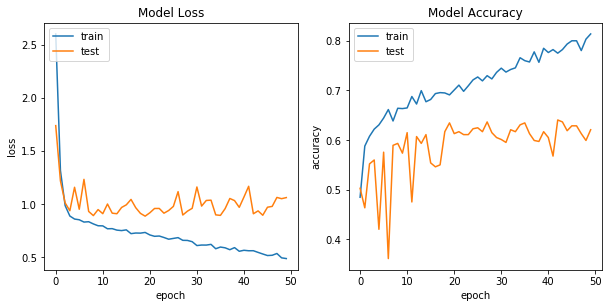

In [18]:
np.random.seed(SEED)

(cnn_model, loss_cnn, acc_cnn, test_score_cnn) = bc.run_network(model=diff_model7_noise_reg, 
                                                                data=data, 
                                                                epochs=50, batch=64)
plt.figure(figsize=(10,10))
bc.plot_losses(loss_cnn, acc_cnn)
plt.savefig('./epoch_figures/jn_Core_CNN_3Class_Learning_20170508.png', dpi=100)

In [19]:
bc.save_model(dir_path='./weights/', model=cnn_model, name='jn_Core_CNN_3Class_20170508')

Model and Weights Saved to Disk


Core CNN Accuracy:   62.08%
Core CNN Error:      37.92%
Normalized confusion matrix
[[ 0.87  0.05  0.07]
 [ 0.08  0.52  0.41]
 [ 0.35  0.2   0.45]]


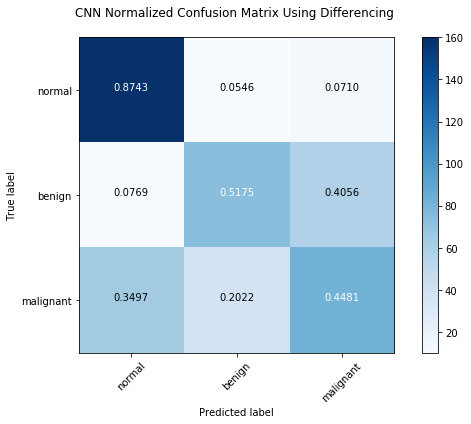

In [20]:
print 'Core CNN Accuracy: {: >7.2f}%'.format(test_score_cnn[1] * 100)
print 'Core CNN Error: {: >10.2f}%'.format(100 - test_score_cnn[1] * 100)

predictOutput = bc.predict(cnn_model, X_test)

cnn_matrix = skm.confusion_matrix(y_true=[val.argmax() for val in Y_test], y_pred=predictOutput)

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(cnn_matrix, classes=class_names, normalize=True,
                         title='CNN Normalized Confusion Matrix Using Differencing \n')
plt.tight_layout()
plt.savefig('./cm_figures/jn_Core_CNN_3Class_CM_20170508.png', dpi=100)